In [1]:
import pandas as pd
import numpy as np
import toad
from xgboost import XGBClassifier as XGB
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
import my_model_lib as my_lib

from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")



In [2]:
target = 'target'
to_drop = []
train_date = ['202210', '202211', '202212']
oot_date = ['202301']


data = pd.read_csv('/Users/apple/Desktop/target2.csv')
data['target'] = data['target'].replace({'good': 0, 'bad': 1})
data = data.drop(columns = to_drop)

data['fill_bill_date'] = data['fill_bill_date'].astype(str)
data['dep_prov_no'] = data['dep_prov_no'].astype(str)
data['usr_job'] = data['usr_job'].astype(str)
data['schooling'] = data['schooling'].astype(str)
data['marital_sta'] = data['marital_sta'].astype(str)

data = data[data['dep_prov_no'] == '22']

columns = list(data.columns)
columns[:-1] = ['X_' + str(i+1) for i in range(len(data.columns)-1)]
data.columns = columns


train_data = data[data['X_1'].isin(train_date)]
oot_data = data[data['X_1'].isin(oot_date)]
train_data = train_data.drop(columns = ['X_1','X_4'])
oot_data = oot_data.drop(columns = ['X_1','X_4'])

# 将数据分割成训练集的比例 55
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_data, test_size=0.2, random_state=32,stratify=train_data[target])
# train_data.shape,oot_data.shape
# toad.detect(train_set)


In [3]:

train_selected, dropped = toad.selection.drop_empty(train_set,threshold = 0.8, return_drop=True)
print('删除缺失值多的变量-后',train_selected.shape)
train_selected.head(3)
# 
# train_selected, dropped = toad.selection.drop_iv(train_selected,threshold = 0.02,return_drop=True)
# print('删除低iv的变量-后',train_selected.shape)
# 
train_selected, dropped = toad.selection.drop_corr(train_selected,target = target,threshold = 0.7, return_drop=True)
print('删除相关性高的变量-后',train_selected.shape)
# 训练集

train_set_X = train_selected.drop(columns=target)
train_set_Y = train_selected[target]

test_set_X = test_set[train_set_X.columns]
test_set_Y = test_set[target]

oot_set_X = oot_data[train_set_X.columns]
oot_set_Y = oot_data[target]

删除缺失值多的变量-后 (25711, 148)
删除相关性高的变量-后 (25711, 55)


In [4]:
# one-hot 转换

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), make_column_selector(dtype_include=object))
    ],
    remainder='passthrough'
)
processed_train_data = preprocessor.fit_transform(train_set_X)
processed_test_data = preprocessor.fit_transform(test_set_X)
processed_oot_data = preprocessor.fit_transform(oot_set_X)
# 获取转换后的特征名称
columns = preprocessor.get_feature_names_out()
# 创建新的DataFrame，使用新的列名
onehot_train_X = pd.DataFrame(processed_train_data, columns=columns)
onehot_test_X = pd.DataFrame(processed_test_data, columns=columns)
onehot_oot_X = pd.DataFrame(processed_oot_data, columns=columns)
print(onehot_train_X.shape, onehot_test_X.shape, onehot_oot_X.shape)
columns

(25711, 82) (6428, 82) (9361, 82)


array(['cat__X_7_1.0', 'cat__X_7_10.0', 'cat__X_7_11.0', 'cat__X_7_12.0',
       'cat__X_7_13.0', 'cat__X_7_14.0', 'cat__X_7_15.0', 'cat__X_7_16.0',
       'cat__X_7_17.0', 'cat__X_7_18.0', 'cat__X_7_19.0', 'cat__X_7_2.0',
       'cat__X_7_20.0', 'cat__X_7_21.0', 'cat__X_7_3.0', 'cat__X_7_4.0',
       'cat__X_7_5.0', 'cat__X_7_6.0', 'cat__X_7_7.0', 'cat__X_7_8.0',
       'cat__X_7_9.0', 'cat__X_7_nan', 'cat__X_8_1', 'cat__X_8_2',
       'cat__X_8_3', 'cat__X_8_4', 'cat__X_8_5', 'cat__X_8_6',
       'cat__X_9_0', 'cat__X_9_1', 'cat__X_10_女', 'cat__X_10_男',
       'remainder__X_2', 'remainder__X_3', 'remainder__X_5',
       'remainder__X_6', 'remainder__X_11', 'remainder__X_12',
       'remainder__X_13', 'remainder__X_14', 'remainder__X_15',
       'remainder__X_16', 'remainder__X_17', 'remainder__X_18',
       'remainder__X_19', 'remainder__X_36', 'remainder__X_37',
       'remainder__X_39', 'remainder__X_52', 'remainder__X_55',
       'remainder__X_59', 'remainder__X_61', 'remainder__X

In [5]:
# xgb = XGB(
#     colsample_bytree= 0.8,
#     learning_rate= 0.1,
#     max_depth= 4,
#     n_estimators= 100,
#     subsample= 0.8,
#     seed=11
# )

xgb = XGB(
    colsample_bytree= 0.8,
    learning_rate= 0.1,
    max_depth= 3,
    n_estimators= 100,
    subsample= 0.7,
    seed=11
)
# 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7
xgb.fit(onehot_train_X,train_set_Y)

xgb_predict_proba = xgb.predict_proba(onehot_train_X)

xgb_def_rate = xgb_predict_proba[:,1]

In [6]:
#计算AUC
fpr, tpr, thresh_lr = roc_curve(train_set_Y,xgb_def_rate)
# 计算 AUC
roc_auc = auc(fpr, tpr)
# 计算 KS 统计量
ks_statistic = np.max(tpr - fpr)
print(f"KS Statistic on Train Set: {ks_statistic}")
print(f"AUC on Test Set: {roc_auc}")

# 测试-- begin
# 使用训练好的模型进行预测
test_predict_proba = xgb.predict_proba(onehot_test_X)[:, 1]
# 真实标签
true_labels = test_set_Y
# 计算 ROC 曲线的各个点
fpr, tpr, thresholds = roc_curve(true_labels, test_predict_proba)
# 计算 KS 统计量
ks_statistic = np.max(tpr - fpr)
# 计算 AUC
roc_auc = auc(fpr, tpr)

print(f"KS Statistic on Test Set: {ks_statistic}")
print(f"AUC on Test Set: {roc_auc}")

# oot-- begin
# 使用训练好的模型进行预测
oot_predict_proba = xgb.predict_proba(onehot_oot_X)[:, 1]
# 真实标签
true_labels = oot_set_Y
# 计算 ROC 曲线的各个点
fpr, tpr, thresholds = roc_curve(true_labels, oot_predict_proba)
# 计算 KS 统计量
ks_statistic = np.max(tpr - fpr)
# 计算 AUC
roc_auc = auc(fpr, tpr)

print(f"KS Statistic on OOT Set: {ks_statistic}")
print(f"AUC on OOT Set: {roc_auc}")

# print('test PSI',my_lib.calculate_model_psi(pred_train, pred_test))
# print('oot PSI',my_lib.calculate_model_psi(pred_train, pred_oot))


KS Statistic on Train Set: 0.5234758472602876
AUC on Test Set: 0.847122469033752
KS Statistic on Test Set: 0.4894355993807076
AUC on Test Set: 0.8242033233153672
KS Statistic on OOT Set: 0.46464162848581897
AUC on OOT Set: 0.8037560441999462


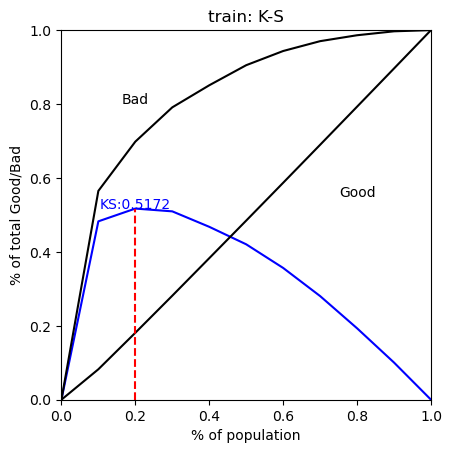

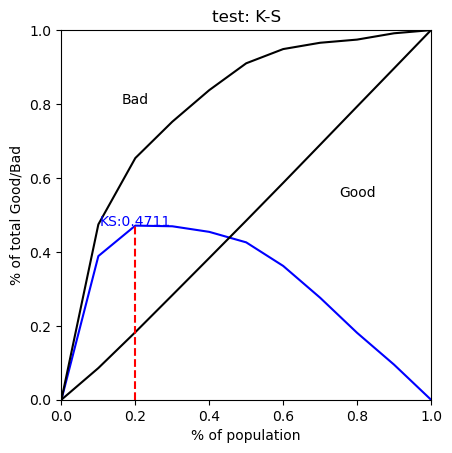

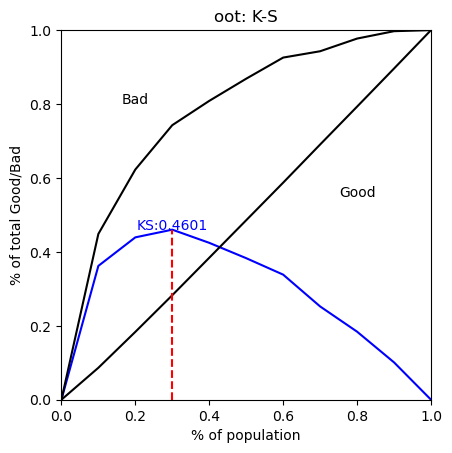

{'KS': 0.4601, 'pic': <Figure size 640x480 with 1 Axes>}

In [7]:
import scorecardpy as sc
# auc和ks值可视化输出
sc.perf_eva(train_set_Y.values,xgb_def_rate,plot_type=["ks"],groupnum=10,title="train")
sc.perf_eva(test_set_Y.values,test_predict_proba,plot_type=["ks"],groupnum=10,title="test")
sc.perf_eva(oot_set_Y.values,oot_predict_proba,plot_type=["ks"],groupnum=10,title="oot")

# sc.perf_eva(train_set_Y.values,xgb_def_rate,plot_type=["roc"])


In [8]:

toad.metrics.KS_bucket(xgb_predict_proba[:,1], train_set_Y, bucket=10, method = 'quantile')


,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.002414,0.006614,3,2568,2571,0.001167,0.998833,0.001168,0.003198,0.103661,...,0.036482,0.003198,1.000000,0.103661,1.000000,0.099996,1.000000,0.100463,0.031984,1.000000
1,0.006614,0.008655,10,2561,2571,0.003890,0.996110,0.003905,0.010661,0.103379,...,0.040406,0.013859,0.996802,0.207040,0.896339,0.199992,0.900004,0.193181,0.106614,1.107553
2,0.008655,0.011208,15,2557,2572,0.005832,0.994168,0.005866,0.015991,0.103217,...,0.044971,0.029851,0.986141,0.310257,0.792960,0.300027,0.800008,0.280406,0.159859,1.232664
3,0.011209,0.014840,25,2545,2570,0.009728,0.990272,0.009823,0.026652,0.102733,...,0.050564,0.056503,0.970149,0.412990,0.689743,0.399984,0.699973,0.356487,0.266639,1.385981
4,0.014842,0.019422,36,2535,2571,0.014002,0.985998,0.014201,0.038380,0.102329,...,0.057367,0.094883,0.943497,0.515319,0.587010,0.499981,0.600016,0.420436,0.383810,1.572454
5,0.019422,0.023577,51,2521,2572,0.019829,0.980171,0.020230,0.054371,0.101764,...,0.066039,0.149254,0.905117,0.617083,0.484681,0.600016,0.500019,0.467829,0.543520,1.810164
6,0.023581,0.028535,56,2511,2567,0.021815,0.978185,0.022302,0.059701,0.101360,...,0.077596,0.208955,0.850746,0.718443,0.382917,0.699856,0.399984,0.509488,0.597968,2.126948
7,0.028539,0.039092,87,2486,2573,0.033813,0.966187,0.034996,0.092751,0.100351,...,0.096151,0.301706,0.791045,0.818795,0.281557,0.799930,0.300144,0.517089,0.926820,2.635552
8,0.039097,0.075923,125,2447,2572,0.048600,0.951400,0.051083,0.133262,0.098777,...,0.127333,0.434968,0.698294,0.917572,0.181205,0.899965,0.200070,0.482604,1.332156,3.490249
9,0.076024,0.984273,530,2042,2572,0.206065,0.793935,0.259549,0.565032,0.082428,...,0.206065,1.000000,0.565032,1.000000,0.082428,1.000000,0.100035,-0.000000,5.648343,5.648343


In [9]:

print(my_lib.calculate_model_psi(xgb_def_rate, test_predict_proba))
print(my_lib.calculate_model_psi(xgb_def_rate, oot_predict_proba))
interval_psi_table = my_lib.calculate_interval_psi(xgb_def_rate, oot_predict_proba, buckets=10)
interval_psi_table

0.0017592711122613386
0.005895164303049764


,Breakpoint Start,Breakpoint End,Expected Proportion,Actual Proportion,Interval PSI
0,0.002414,0.006614,0.099996,0.087500,0.001668
1,0.006614,0.008655,0.099996,0.103526,0.000122
2,0.008655,0.011208,0.099996,0.097650,0.000056
3,0.011208,0.014842,0.099996,0.089103,0.001256
4,0.014842,0.019422,0.099996,0.106197,0.000373
5,0.019422,0.023577,0.099996,0.106303,0.000386
6,0.023577,0.028539,0.099879,0.113889,0.001839
7,0.028539,0.039097,0.100074,0.099573,0.000003
8,0.039097,0.076024,0.100035,0.095726,0.000190
9,0.076024,0.984273,0.100035,0.100534,0.000002


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设xgb是已经训练好的XGBoost模型
# train_set_X是用于训练模型的特征数据集
train_set_X

,X_2,X_3,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,...,X_134,X_138,X_144,X_146,X_147,X_148,X_150,X_151,X_152,X_205
81026,0,750,1,1,1.0,6,1,女,24,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
12887,0,1200,1,1,1.0,6,1,女,38,0.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.35
90274,0,750,1,3,nan,5,1,男,53,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.84
62004,0,950,1,3,6.0,6,1,男,49,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
86699,0,1460,1,2,21.0,6,1,女,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44267,0,750,1,2,1.0,6,1,男,53,0.0,...,0.0,0.0,8192.0,0.0,0.0,0.0,0.0,0.0,0.0,90.66
29951,0,1200,1,3,6.0,6,1,女,51,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.00
43429,142,1570,1,4,21.0,4,1,男,47,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.13
56572,0,950,1,2,6.0,6,0,女,28,0.0,...,0.0,0.0,13059.0,0.0,0.0,0.0,3.0,0.0,3.0,53.99


In [11]:

# 获取特征重要性并创建一个DataFrame
feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index=onehot_train_X.columns,
                                   columns=['importance'])

# 对特征重要性进行降序排序
sorted_features = feature_importances.sort_values(by='importance', ascending=False)

# 选择前30个最重要的特征
# top_30_features = sorted_features.head(30)
top_30_features = sorted_features[sorted_features['importance']>0.02]

# 打印结果
top_30_features

,importance
remainder__X_91,0.066127
remainder__X_14,0.049485
remainder__X_3,0.041549
cat__X_9_0,0.038137
cat__X_9_1,0.037886
remainder__X_106,0.030080
cat__X_10_女,0.029716
remainder__X_152,0.027564
remainder__X_148,0.026988
remainder__X_151,0.024907
